In [1]:
from utils import *
import numpy as np
import pickle
import wandb

In [2]:
index_to_english_alphabet=pickle.load(open('vocab_tools/index_to_english_alphabet.pickle', 'rb'))
index_to_hindi_alphabet=pickle.load(open('vocab_tools/index_to_hindi_alphabet.pickle', 'rb'))

hindi_alphabet_to_index=pickle.load(open('vocab_tools/hindi_alphabet_to_index.pickle', 'rb')) 
english_alphabet_to_index=pickle.load(open('vocab_tools/english_alphabet_to_index.pickle', 'rb')) 

In [3]:
X_train=np.load('simple_data/X_train.npy')
X_valid=np.load('simple_data/X_val.npy')

y_train=np.load('simple_data/y_train.npy')
y_valid=np.load('simple_data/y_val.npy')

In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/opt/anaconda/envs/shared_conda_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class Eng_Hind_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, in_file, out_file, root_dir='simple_data',device='cuda'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input = torch.tensor(np.load(root_dir+'/'+in_file))
        self.output = torch.tensor(np.load(root_dir+'/'+out_file))
        
        assert(len(self.input)==len(self.output),"Error: I/O Lengths must be same")
        

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        X=self.input[idx]
        X=X.to(device)
        y=self.output[idx]
        y=y.to(device)
        


        sample = {'input': X, 'output': y}

        return sample

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

In [8]:
training_data=Eng_Hind_Dataset("X_train.npy","y_train.npy",device=device)
val_data=Eng_Hind_Dataset("X_val.npy","y_val.npy",device=device)
test_data=Eng_Hind_Dataset("X_test.npy","y_test.npy",device=device)

In [9]:
train_val_sets = torch.utils.data.ConcatDataset([training_data, val_data])

train_val_dataloader = DataLoader(train_val_sets, batch_size=16,shuffle=True)

In [10]:
test_dataloader = DataLoader(test_data, batch_size=16,shuffle=True)

In [11]:
import torch.nn as nn

In [12]:
def cell_type(mode:str='rnn'):
    mode=mode.lower()
    if mode == 'rnn':
        return nn.RNN
    elif mode =='gru':
        return nn.GRU
    else:
        return nn.LSTM
        

In [13]:
class Encoder(nn.Module):


    def __init__(self, input_size, embed_size, enc_hid_size, dec_hid_size, num_layers, cell_mode, dropout, is_bi):
        super().__init__()
        
        # create embedding layer
        self.embedding = nn.Embedding(input_size, embed_size,padding_idx=english_alphabet_to_index['.'])

        #creating LSTM/GRU/RNN cell
        cell=cell_type(cell_mode)
        
        self.cell=cell(embed_size,enc_hid_size,num_layers,dropout=dropout,bidirectional=is_bi,batch_first=True)
        self.cell_mode=cell_mode
        self.is_bi=is_bi
        if is_bi:
            self.fc=nn.Linear(enc_hid_size*2, dec_hid_size)
        else:
            self.fc=nn.Linear(enc_hid_size, dec_hid_size)
        
        

    def forward(self, input_batch: torch.LongTensor):
        
        embedded = self.embedding(input_batch) # [sent len, batch size, emb dim]
        
        if self.cell_mode.lower()=='lstm':
            outputs, (hidden, cell) = self.cell(embedded)
            
            if self.is_bi:
                concated = torch.cat((hidden[ -2, :,:], hidden[ -1, :,:]), dim=1)
                cellconcat=torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)
            else:
                concated = hidden[ -1,:, :]
                cellconcat= cell[ -1,:, :]
            
            hidden = torch.tanh(self.fc(concated))
            
            cell=torch.tanh(self.fc(cellconcat))


            return outputs,hidden,cell
        
        else:
            outputs, hidden = self.cell(embedded)           
            if self.is_bi:
                concated = torch.cat((hidden[ -2, :,:], hidden[ -1, :,:]), dim=1)

            else:
                concated = hidden[ -1,:, :]

            hidden = torch.tanh(self.fc(concated))

            return outputs,hidden

        


In [14]:
class Attention(nn.Module):

    def __init__(self, enc_hid_dim, dec_hid_dim, is_bi):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        if is_bi:
            self.fc1 = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)
        else:
            self.fc1 = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim)
            

            
        self.fc2 = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        src_len = encoder_outputs.shape[1]
        batch_size = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        outputs = encoder_outputs
        
        concat = torch.cat((hidden, outputs), dim=2)
        energy = torch.tanh(self.fc1(concat))

        attention = self.fc2(energy).squeeze(dim=2)        
        attention_weight = torch.softmax(attention, dim=1)
        return attention_weight

In [127]:
class Attheat:
    def __init__(self,att):
        self.att=att
    
    def forward(self, encoder_outputs, hidden):
        src_len = encoder_outputs.shape[1]
        batch_size = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        outputs = encoder_outputs
        
        concat = torch.cat((hidden, outputs), dim=2)
        energy = torch.tanh(self.att.fc1(concat))

        attention = self.att.fc2(energy) 
#         attention_weight = torch.softmax(attention, dim=1)
        return attention

In [15]:
class Decoder(nn.Module):

    def __init__(self, output_size, embed_size, enc_hid_dim, dec_hid_dim, num_layers, cell_mode,\
                 dropout, attention, is_bi):
        super().__init__()
    
        self.dropout = dropout
        self.attention = attention
        self.output_size=output_size

        self.embedding = nn.Embedding(output_size, embed_size,padding_idx=hindi_alphabet_to_index['.'])
        cell=cell_type(cell_mode)
        self.cell_mode=cell_mode.lower()
        
        
        if is_bi:
            self.cell=cell((enc_hid_dim * 2) + embed_size, dec_hid_dim,num_layers,\
                           dropout=dropout,bidirectional=False,batch_first=False)
        

        else:
            self.cell=cell(enc_hid_dim + embed_size, dec_hid_dim,num_layers,\
                           dropout=dropout,bidirectional=False,batch_first=False)
            
        
        
        self.out = nn.Linear(dec_hid_dim, output_size)

    def forward(self, trg, encoder_outputs, hidden,cell=None):
 
        attention = self.attention(encoder_outputs, hidden).unsqueeze(1)
        context = torch.bmm(attention, encoder_outputs).permute(1, 0, 2)

        # input sentence -> embedding
        # [1, batch size, emb dim]
        embedded = self.embedding(trg.unsqueeze(0))
        cell_input = torch.cat((embedded, context), dim=2)
        
        if self.cell_mode=='lstm':
            outputs, (hidden,cell) = self.cell(cell_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
            prediction = self.out(outputs.squeeze(0))
            return prediction, hidden.squeeze(0), cell.squeeze(0)
            

        outputs, hidden = self.cell(cell_input, hidden.unsqueeze(0))
        prediction = self.out(outputs.squeeze(0))
        return prediction, hidden.squeeze(0)

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device


    def forward(self, source_batch, target_batch, teacher_forcing_ratio=0.5):

        batch_size,max_len  = target_batch.shape
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(max_len, batch_size, target_vocab_size).to(self.device)

        # last hidden & cell state of the encoder is used as the decoder's initial hidden state
        if self.encoder.cell_mode=='lstm':
            e_outs,hidden,cell = self.encoder(source_batch) 
            
            trg = target_batch[:,0]
            for i in range(1, max_len):
                prediction, hidden, cell = self.decoder(trg,e_outs, hidden, cell)
                outputs[i] = prediction

                if np.random.random() < teacher_forcing_ratio:
                    trg = target_batch[:,i]
                else:
                    trg = prediction.argmax(1)
            return outputs

            
            
        else:    
            e_outs,hidden = self.encoder(source_batch)       

            trg = target_batch[:,0]
            for i in range(1, max_len):
                prediction, hidden = self.decoder(trg,e_outs, hidden)
                outputs[i] = prediction

                if np.random.random() < teacher_forcing_ratio:
                    trg = target_batch[:,i]
                else:
                    trg = prediction.argmax(1)

            return outputs


        
        

In [17]:
def accuracy_calc(target_seq,seq2,mode='full',device=device):# predicted
    eos_index=(target_seq==hindi_alphabet_to_index['>']).nonzero()
    eos_idx=eos_index[:,1]
    
    correct=torch.Tensor([0]).to(device)
    correct_chars=torch.Tensor([0]).to(device)
    tot_chars=torch.Tensor([0]).to(device)
    for iterate,idx in enumerate(eos_idx):
        inputter=seq2[iterate][:idx]
        outputter=target_seq[iterate][:idx]
        if torch.all(torch.eq(inputter,outputter)):
            correct+=1
            correct_chars+=idx
            tot_chars+=idx
        else:
            correct_chars+=torch.sum(inputter == outputter).item()
            tot_chars+=idx
            
#         print(correct,correct_chars,tot_chars)
        
    return correct.item(),correct_chars.item(),tot_chars.item()
            
            
        
    

In [18]:
def train(seq2seq, iterator, optimizer, criterion):
    
    
    seq2seq.train()
    
    epoch_loss = 0
    correct=0
    correct_char=0
    tot_char=0
    
    relax_acc=0
    
    
    for batch in iterator:
        optimizer.zero_grad()
        outputs = seq2seq(batch['input'], batch['output'])
        batch_label=batch['output'].transpose(0,1)
        batch_size=len(batch['output'])
        
        _, predicted = torch.max(outputs, dim=2)
        outputs_flatten = outputs.view(-1, outputs.shape[-1])
        trg_flatten = batch_label.reshape(-1)
        

        trg_flatten.requires_grad=False
        loss = criterion(outputs_flatten, trg_flatten)
        correct_temp,correct_chars_temp,tot_chars_temp=accuracy_calc(batch['output'],predicted.transpose(0,1))
        
        #___________
        
        correct+=correct_temp
        correct_char+=correct_chars_temp
        tot_char+=tot_chars_temp
        
        
        #_______________
        

        loss.backward()
        optimizer.step()
        

        epoch_loss += loss.item()
        


    return epoch_loss / len(iterator), correct/(len(iterator)*16),correct_char/tot_char

In [19]:
def evaluate(seq2seq, iterator, criterion):
    seq2seq.eval()

    epoch_loss = 0
    correct=0
    correct_char=0
    tot_char=0
    
    relax_acc=0
    
    with torch.no_grad():
        for batch in iterator:
            outputs = seq2seq(batch['input'], batch['output'],teacher_forcing_ratio=0)
            batch_label=batch['output'].transpose(0,1)
            batch_size=len(batch['output'])


            _, predicted = torch.max(outputs, dim=2)
            #print('wow_preds',predicted.shape)

            outputs_flatten = outputs.view(-1, outputs.shape[-1])
            trg_flatten = batch_label.reshape(-1)

            loss = criterion(outputs_flatten, trg_flatten)
            
            correct_temp,correct_chars_temp,tot_chars_temp=accuracy_calc(batch['output'],predicted.transpose(0,1))
        
            #___________

            correct+=correct_temp
            correct_char+=correct_chars_temp
            tot_char+=tot_chars_temp

            #_______________       
            
            epoch_loss += loss.item()
            

    return epoch_loss / len(iterator), correct/(len(iterator)*16),correct_char/tot_char



In [20]:
def epoch_time(start_time, end_time):
    e_time = end_time - start_time
    mins = e_time // 60
    secs = e_time%60
    return mins, secs,

In [21]:
def count_params(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [22]:
import time
import random

In [23]:
import torch.optim as optim
def make_model(train_iterator,valid_iterator, enc_embed_size, enc_hid_size, dec_embed_size, dec_hid_size,\
               num_layers, cell_mode,\
                 dropout, is_bi, epochs=20):
    
    
    E = Encoder(30,  embed_size=enc_embed_size, enc_hid_size=enc_hid_size, dec_hid_size=dec_hid_size,\
                num_layers=num_layers, cell_mode=cell_mode, dropout=dropout, is_bi=is_bi).to(device)
    
    
    A = Attention(enc_hid_dim=enc_hid_size, dec_hid_dim=dec_hid_size, is_bi=is_bi).to(device)

    D = Decoder(68, embed_size=dec_embed_size, enc_hid_dim=enc_hid_size, dec_hid_dim=dec_hid_size,\
                num_layers=1, cell_mode=cell_mode,\
                 dropout=dropout, attention=A, is_bi=is_bi).to(device)

    S=Seq2Seq(E,D,device)
    S.to(device)    
    print(f'The model has {count_params(S):,} trainable parameters')
    
    optimizer = optim.Adam(S.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=hindi_alphabet_to_index['.'])
    criterion=criterion.to(device)
    
    best_valid_loss = float('inf')
#     return S

    for epoch in range(epochs):    
        start_time = time.time()
        train_loss,train_acc,train_stuff = train(S, train_iterator, optimizer, criterion)
        valid_loss,valid_acc,val_stuff = evaluate(S, valid_iterator, criterion)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(S.state_dict(), 'model1.pt')

        # it's easier to see a change in perplexity between epoch as it's an exponential
        # of the loss, hence the scale of the measure is much bigger
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print(f'\t Relaxed Train. Acc: {train_stuff*100:.2f}% | Relaxed Val. Acc: {val_stuff*100:.2f}%')
        
        
    return S

    

In [24]:
# train_iterator=train_val_dataloader
# valid_iterator=test_dataloader
# SS=make_model(train_iterator,valid_iterator,cell_mode='lstm',dec_embed_size=16,dec_hid_size=128,\
#               dropout=0.2,enc_embed_size=32,enc_hid_size=256,epochs=30,is_bi=True,num_layers=3)

In [26]:
# # The second saves and loads the entire model:

# torch.save(SS, 'attn_model.model')



In [27]:
# Then later:

the_model = torch.load('attn_model.model')


In [28]:
test_full_dataloader = DataLoader(test_data, batch_size=len(test_data),shuffle=False)

In [29]:
# del SS

the_model.eval()
preds=the_model(next(iter(test_full_dataloader))['input'],next(iter(test_full_dataloader))['output'],teacher_forcing_ratio=0)

In [30]:
_, predicted = torch.max(preds, dim=2)

In [31]:
predicted

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [29, 35, 21,  ..., 47, 25, 18],
        [ 4,  4,  6,  ...,  9,  4,  6],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]], device='cuda:0')

In [32]:
import math

In [33]:
def word_from_torchies(torchie1,index_toalp):
    torchie=torchie1.cpu().numpy()
    return word_from_vecs(torchie,index_toalp,False)

In [34]:
def word_from_batch(batch):
    wordlet=[]
    for i in range(len(batch)):
        wordlet.append(word_from_torchies(batch[i],index_to_hindi_alphabet))
    return wordlet
        

In [35]:
def word_from_batch_eng(batch):
    wordlet=[]
    for i in range(len(batch)):
        wordlet.append(word_from_torchies(batch[i],index_to_english_alphabet))
    return wordlet

In [36]:
test_preds=word_from_batch(predicted.transpose(0,1))

In [37]:
test_actual=word_from_batch(next(iter(test_full_dataloader))['output'])

In [38]:
test_input=word_from_batch_eng(next(iter(test_full_dataloader))['input'])

In [173]:
np.savetxt('predictions_attention.txt',test_preds, delimiter=',',encoding='utf-8',fmt='%s')

In [181]:
va=np.loadtxt('predictions_vanilla.txt',delimiter=',',encoding='utf-8',dtype=str)

array(['सिखाएगा', 'लीरन', 'ट्विटर्स', ..., 'खातूटोला', 'शिवास्तवा',
       'प्रेरणापुरी'], dtype='<U21')

In [185]:
import pandas as pd
datas={'Ground truth':test_actual,'Predictions Attention':test_preds, "Predictions Vanilla":va}
df=pd.DataFrame(data=datas,index=test_input)


In [191]:
xx=df[df['Predictions Attention']!=df['Predictions Vanilla']]

In [194]:
yy=xx[xx['Predictions Attention']==xx['Ground truth']]


In [195]:
yy

,Ground truth,Predictions Attention,Predictions Vanilla
shikayatkarta,शिकायतकर्ता,शिकायतकर्ता,शिकटयाकर्ता
kaarniyaan,कार्नियां,कार्नियां,कारनियाँ
holt,होल्ट,होल्ट,हॉल्ट
laigikata,लैंगिकता,लैंगिकता,लैईगीकता
vankshetra,वनक्षेत्र,वनक्षेत्र,वंक्षेत्र
...,...,...,...
francisco,फ्रांसिस्को,फ्रांसिस्को,फ्रैंसिस्को
raghavan,राघवन,राघवन,रघवन
thaki,थकी,थकी,ठकी
punchang,पंचांग,पंचांग,पुंचांग


In [197]:
zz=xx[xx['Predictions Vanilla']==xx['Ground truth']]

In [198]:
zz

,Ground truth,Predictions Attention,Predictions Vanilla
twitters,ट्विटर्स,ट्वियरटर्स,ट्विटर्स
ukhrul,उखरुल,उखरूल,उखरुल
iqbal,इक़बाल,इकबाल,इक़बाल
umanath,उमानाथ,उमनाथ,उमानाथ
sushrushaa,सुश्रुषा,सुष्रशषा,सुश्रुषा
...,...,...,...
prapt,प्राप्त,प्रप्त,प्राप्त
kanthahar,कंठहार,कंठहर,कंठहार
oxide,ऑक्साइड,आक्साइड,ऑक्साइड
shbana,शबाना,श्बाना,शबाना


In [184]:
df_correct=df[df['Ground truth']==df['Predictions']]

KeyError: 'Predictions'

In [42]:
df_correct

,Ground truth,Predictions
sikhaaega,सिखाएगा,सिखाएगा
tirunelveli,तिरुनेलवेली,तिरुनेलवेली
independence,इंडिपेंडेंस,इंडिपेंडेंस
speshiyon,स्पेशियों,स्पेशियों
kolhapur,कोल्हापुर,कोल्हापुर
...,...,...
khairati,खैराती,खैराती
deshke,देशके,देशके
seho,सेहो,सेहो
belcha,बेलचा,बेलचा


In [43]:
df_incorrect=df[df['Ground truth']!=df['Predictions']]

In [44]:
df_incorrect

,Ground truth,Predictions
learn,लर्न,लियन
twitters,ट्विटर्स,ट्वियरटर्स
shurooh,शुरूः,शुरूह
ajhar,अजहर,अझर
karaar,क़रार,करार
...,...,...
miti,मिति,मिटी
saflata,सफ़लता,सफलाता
shbana,शबाना,श्बाना
khaatootolaa,खातूटोला,खातूतोला


In [72]:
import copy
E=copy.deepcopy(the_model.encoder)
A=copy.deepcopy(the_model.decoder.attention)
D=copy.deepcopy(the_model.decoder)


In [50]:
test_single_dataloader = DataLoader(test_data, batch_size=1,shuffle=False)

In [51]:
word=next(iter(test_single_dataloader))

In [52]:
word

{'input': tensor([[ 0, 19,  4, 10,  7,  9,  9, 17, 13,  9,  1,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]], device='cuda:0'),
 'output': tensor([[ 0, 29,  4, 47,  9, 41, 22,  9,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]], device='cuda:0')}

In [153]:
o,h,c=E(word['input'])

In [154]:
atts=A(o,h)

In [159]:
dd=D.embedding(word['output']).squeeze(0)

In [160]:
aa=atts.squeeze(0)

In [161]:
ee=E.embedding(word['input']).squeeze(0)

In [162]:
jj=torch.multiply(ee.transpose(0,1),aa)

In [163]:
jj.shape

torch.Size([32, 30])

In [164]:
torch.matmul(jj,dd)

tensor([[ 0.1035, -0.3291,  0.4867,  0.5475,  0.4460,  0.2327, -0.6832,  0.6169,
         -0.2406, -0.1695,  0.4852,  0.1325,  0.0606, -0.9081, -0.6675, -0.6335],
        [ 0.0470, -0.1499,  0.2212,  0.2489,  0.2028,  0.1059, -0.3110,  0.2807,
         -0.1095, -0.0770,  0.2208,  0.0601,  0.0274, -0.4134, -0.3036, -0.2882],
        [ 0.1114, -0.3534,  0.5240,  0.5891,  0.4799,  0.2502, -0.7344,  0.6634,
         -0.2586, -0.1824,  0.5216,  0.1430,  0.0654, -0.9761, -0.7181, -0.6815],
        [-0.0205,  0.0654, -0.0966, -0.1087, -0.0886, -0.0463,  0.1358, -0.1225,
          0.0478,  0.0336, -0.0964, -0.0262, -0.0120,  0.1804,  0.1325,  0.1258],
        [ 0.0290, -0.0914,  0.1366,  0.1531,  0.1250,  0.0653, -0.1907,  0.1725,
         -0.0668, -0.0472,  0.1353,  0.0372,  0.0174, -0.2533, -0.1863, -0.1773],
        [-0.2183,  0.6942, -1.0266, -1.1550, -0.9408, -0.4906,  1.4414, -1.3013,
          0.5077,  0.3577, -1.0236, -0.2798, -0.1277,  1.9158,  1.4084,  1.3365],
        [ 0.0227, -0.0

In [169]:
import seaborn as sns

In [172]:
import pandas as pd

In [171]:
pd.DataFrame(torch.matmul(jj,dd).detach().cpu().numpy(),index=index_to_english_alphabet)

ValueError: Shape of passed values is (32, 16), indices imply (29, 16)

<AxesSubplot:>

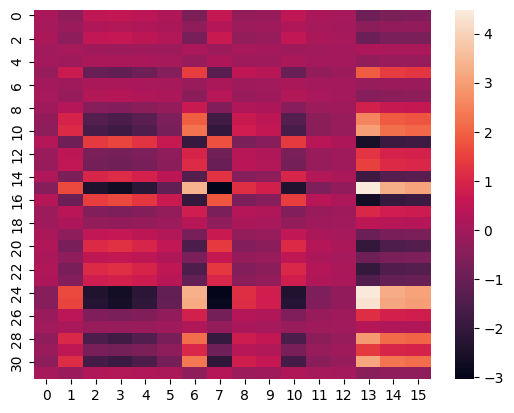

In [168]:
sns.heatmap()

In [67]:
A(o,h)

In [70]:
atts.forward(o,h).shape

torch.Size([1, 30])

In [ ]:
impor